# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from scipy import signal


from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex, load_u_diode_nxcals
from src.modeling.sec_quench import *

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Read the (clean) MP3 file

In [3]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2021_11_22_processed_filled.csv")
len(mp3_fpa_df)

4399

# Select events to download

In [4]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])

In [5]:
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 


mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

828 3996


In [6]:
int(mp3_fpa_df_period[mp3_fpa_df_period["Date (FGC)"]=="2016-06-10 00:00:00"].timestamp_fgc)

1465578785320000000

# Define Paths

In [9]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')

data_path = file_path / 'data'
simulation_path = file_path / 'PSPICE'
plots_path = file_path / 'plots'

#data_dir = data_path / (fpa_identifier + ".hdf5")
#simulation_dir = simulation_path / Path(fpa_identifier) / "simulation.hdf5"

## Analyze one event

In [12]:
row = {'circuit_type': 'RB',
       'Circuit Name': 'RB.A78',
       'timestamp_fgc': 1616962174400000000}

fpa_identifier = f"{row['circuit_type']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
data_dir = data_path / (fpa_identifier + ".hdf5")

Text(0, 0.5, 'weight')

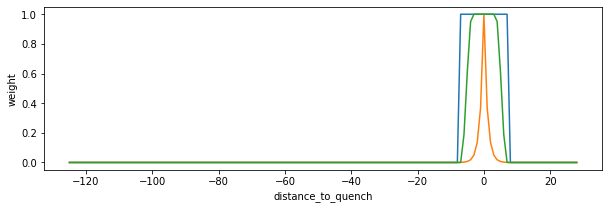

In [32]:
plt.figure(figsize=(10,3))
x = np.arange(-125,29)
plt.plot(x, fit_window_to_data(signal.windows.boxcar(15), 154, 125))
plt.plot(x, fit_window_to_data(signal.windows.exponential(15), 154, 125))
plt.plot(x, fit_window_to_data(signal.windows.tukey(15), 154, 125))
plt.xlabel("distance_to_quench")
plt.ylabel("weight")

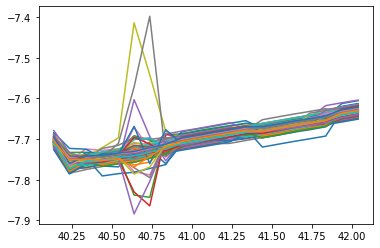

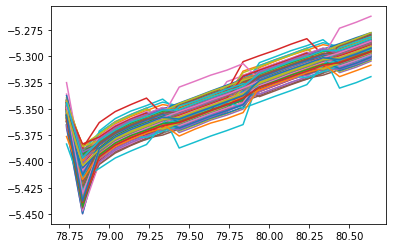

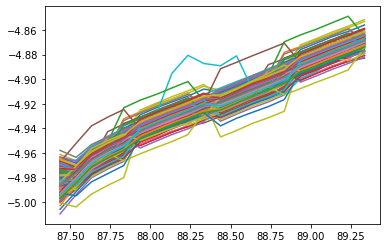

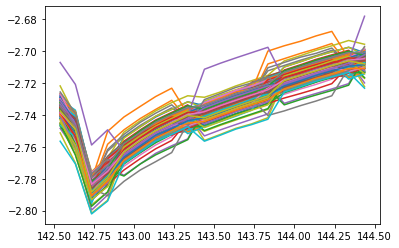

In [13]:
df_data_nxcals = load_u_diode_nxcals(data_dir)

mp3_fpa_df_subset = mp3_fpa_df[mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']]

sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                 all_quenched_magnets=mp3_fpa_df_subset.Position.values, 
                                 quench_times=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3, 
                                 time_frame=2)

for df in sec_quenches:
    df.plot(legend=False)

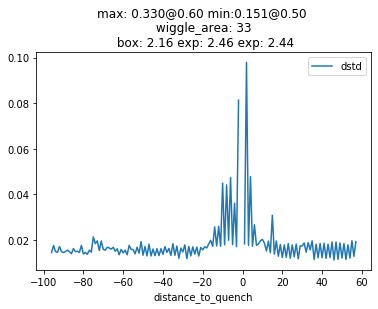

In [14]:
for sec_quench_number, df_quench_frame in enumerate(sec_quenches):
    df_std = get_std_of_diff(df=df_quench_frame)
    
    df_std_meta = sort_by_metadata(
        df=df_std, 
        quenched_magnet=mp3_fpa_df_subset.Position.values[sec_quench_number+1],
        circuit=row["Circuit Name"],
        by="Position")
    
    dstd_score = get_dstd_score(df_std_meta, window_len=15)
    dstd_score_exp = get_dstd_score(df_std_meta, window_len=15, window_function=signal.windows.exponential, tau=2)
    dstd_score_tuk = get_dstd_score(df_std_meta, window_len=15, window_function=signal.windows.tukey)
    
    idx_0 = df_quench_frame.index[0]
    idx_min = df_quench_frame.min(axis=1).idxmin()
    idx_max = df_quench_frame.max(axis=1).idxmax()
    min_time = idx_min - idx_0
    max_time = idx_max - idx_0
    min_amplitude = df_quench_frame.loc[idx_min].mean() -df_quench_frame.loc[idx_min].min() 
    max_amplitude = df_quench_frame.loc[idx_max].max() - df_quench_frame.loc[idx_max].mean()
    
    wiggle_area = calc_wiggle_area(df_std_meta)
    
    df_std_meta["dstd_medfilt"] = df_std_meta.dstd.rolling(3).median()
    df_std_meta.plot(x ="distance_to_quench", y=["dstd"])
    plt.title(f"max: {max_amplitude:.3f}@{max_time:.2f} min:{min_amplitude:.3f}@{min_time:.2f} \n wiggle_area: {wiggle_area} \n box: {dstd_score:.2f} exp: {dstd_score_exp:.2f} exp: {dstd_score_tuk:.2f}")
    
    break

## Analyze all events

In [128]:
df_results = mp3_fpa_df_period_all[['Circuit Family','Circuit Name','timestamp_fgc','Position']]
time_frame_after_qench = 2

good_plots_path = sorted(glob.glob(str(file_path / Path("plots_data_analyzed") / "*.png")))
good_plots_identifier = [Path(g).name[:-4] for g in good_plots_path]
len(good_plots_identifier)

589

In [141]:
for k, fpa_identifier in enumerate(good_plots_identifier):
    
    circuit_name = fpa_identifier.split("_")[1]
    timestamp_fgc = int(fpa_identifier.split("_")[2])
    
    data_dir = data_path / (fpa_identifier + ".hdf5")
    df_data_nxcals = load_u_diode_nxcals(data_dir)
    
    df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & (mp3_fpa_df["Circuit Name"] == circuit_name)]
    print(f"{k}/{len(good_plots_identifier)} {fpa_identifier} n_quenches:{len(df_subset)} len_data:{len(df_data_nxcals)}")
    
    
    sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                     all_quenched_magnets=df_subset.Position.values, 
                                     quench_times=df_subset["Delta_t(iQPS-PIC)"].values /1e3, 
                                     time_frame=time_frame_after_qench)
    
    for sec_quench_number, df_quench_frame in enumerate(sec_quenches):
        if not df_quench_frame.empty:
            df_std = get_std_of_diff(df=df_quench_frame)

            df_std_meta_pos = sort_by_metadata(                                    
                df=df_std, 
                quenched_magnet=df_subset.Position.values[sec_quench_number+1],
                circuit=circuit_name,
                by="Position")

            df_std_meta_elpos = sort_by_metadata(                                    
                df=df_std, 
                quenched_magnet=df_subset.Position.values[sec_quench_number+1],
                circuit=circuit_name,
                by="#Electric_EE")

            # Log result in df
            mask = (df_results['timestamp_fgc']==timestamp_fgc) & (df_results["Circuit Name"] == circuit_name) & (df_results['Position']==df_subset.Position.values[sec_quench_number+1])     
            df_results.loc[mask, "sec_quench_number"] = sec_quench_number

            idx_0 = df_quench_frame.index[0]
            idx_min = df_quench_frame.min(axis=1).idxmin()
            idx_max = df_quench_frame.max(axis=1).idxmax()
            df_results.loc[mask, "min_time"] = idx_min - idx_0
            df_results.loc[mask, "max_time"] = idx_max - idx_0
            df_results.loc[mask, "min_amplitude"] = df_quench_frame.loc[idx_min].mean() -df_quench_frame.loc[idx_min].min() 
            df_results.loc[mask, "max_amplitude"] = df_quench_frame.loc[idx_max].max() - df_quench_frame.loc[idx_max].mean()
            df_results.loc[mask, "dU_max"] = df_quench_frame.diff().max().max()
            df_results.loc[mask, "dU_min"] = df_quench_frame.diff().min().min()
            df_results.loc[mask, "dstd_max"] = df_std.dstd.max()
            df_results.loc[mask, "dstd_mean"] = df_std.dstd.mean()

            df_results.loc[mask, "dstd_score_pos_15"] = get_dstd_score(df_std_meta_pos, window_len=15)
            df_results.loc[mask, "dstd_score_elpos_15"] = get_dstd_score(df_std_meta_elpos, window_len=15)
            df_results.loc[mask, "dstd_score_pos_15_exp"] = get_dstd_score(df_std_meta_pos, window_len=15, window_function=signal.windows.exponential)
            df_results.loc[mask, "dstd_score_elpos_15_exp"] = get_dstd_score(df_std_meta_elpos, window_len=15, window_function=signal.windows.exponential)
            df_results.loc[mask, "dstd_score_pos_15_tuk"] = get_dstd_score(df_std_meta_pos, window_len=15, window_function=signal.windows.tukey)
            df_results.loc[mask, "dstd_score_elpos_15_tuk"] = get_dstd_score(df_std_meta_elpos, window_len=15, window_function=signal.windows.tukey)

            df_results.loc[mask, "wiggle_area_pos"] = calc_wiggle_area(df_std_meta_pos)
            df_results.loc[mask, "wiggle_area_elpos"] = calc_wiggle_area(df_std_meta_elpos)

0/589 RB_RB.A12_1544419882440000000 n_quenches:6 len_data:5500
1/589 RB_RB.A12_1619196160600000000 n_quenches:4 len_data:5500
2/589 RB_RB.A12_1619244358440000000 n_quenches:4 len_data:5500
3/589 RB_RB.A12_1619349125540000000 n_quenches:5 len_data:5500
4/589 RB_RB.A12_1619374541080000000 n_quenches:6 len_data:5500
5/589 RB_RB.A12_1619417171040000000 n_quenches:7 len_data:5500
6/589 RB_RB.A12_1619462088820000000 n_quenches:5 len_data:5500
7/589 RB_RB.A12_1619500720320000000 n_quenches:8 len_data:5500
8/589 RB_RB.A12_1619528422340000000 n_quenches:6 len_data:5500
9/589 RB_RB.A12_1619586892680000000 n_quenches:7 len_data:5500
10/589 RB_RB.A12_1619642471520000000 n_quenches:5 len_data:5500
11/589 RB_RB.A12_1619674435020000000 n_quenches:5 len_data:5500
12/589 RB_RB.A12_1619730140520000000 n_quenches:5 len_data:5500
13/589 RB_RB.A12_1619804543280000000 n_quenches:4 len_data:5500
14/589 RB_RB.A12_1619859877220000000 n_quenches:6 len_data:5500
15/589 RB_RB.A12_1619897616540000000 n_quenches:8 

128/589 RB_RB.A34_1617168543820000000 n_quenches:4 len_data:5500
129/589 RB_RB.A34_1617290609520000000 n_quenches:4 len_data:5500
130/589 RB_RB.A34_1617342231140000000 n_quenches:4 len_data:5500
131/589 RB_RB.A34_1617389807160000000 n_quenches:4 len_data:5500
132/589 RB_RB.A34_1617426291140000000 n_quenches:9 len_data:5500
133/589 RB_RB.A34_1617467320360000000 n_quenches:4 len_data:5500
134/589 RB_RB.A34_1617518210920000000 n_quenches:6 len_data:5500
135/589 RB_RB.A34_1617560138980000000 n_quenches:4 len_data:5500
136/589 RB_RB.A34_1617602423900000000 n_quenches:7 len_data:5500
137/589 RB_RB.A34_1617637140080000000 n_quenches:4 len_data:5500
138/589 RB_RB.A34_1617686185620000000 n_quenches:9 len_data:5500
139/589 RB_RB.A34_1617737526700000000 n_quenches:4 len_data:5500
140/589 RB_RB.A34_1617911657680000000 n_quenches:4 len_data:5500
141/589 RB_RB.A34_1617945608080000000 n_quenches:5 len_data:5500
142/589 RB_RB.A34_1617983920180000000 n_quenches:5 len_data:5500
143/589 RB_RB.A34_1618034

254/589 RB_RB.A45_1620797547820000000 n_quenches:6 len_data:5500
255/589 RB_RB.A45_1620839123520000000 n_quenches:5 len_data:5500
256/589 RB_RB.A45_1620888774060000000 n_quenches:8 len_data:5500
257/589 RB_RB.A45_1620929974240000000 n_quenches:5 len_data:5500
258/589 RB_RB.A45_1620975308380000000 n_quenches:4 len_data:5500
259/589 RB_RB.A45_1621001422840000000 n_quenches:10 len_data:5500
260/589 RB_RB.A45_1621060585460000000 n_quenches:7 len_data:5500
261/589 RB_RB.A45_1621098531980000000 n_quenches:3 len_data:5500
262/589 RB_RB.A45_1621148585120000000 n_quenches:4 len_data:5500
263/589 RB_RB.A45_1621180344020000000 n_quenches:5 len_data:5500
264/589 RB_RB.A45_1621230431820000000 n_quenches:6 len_data:5500
265/589 RB_RB.A45_1621277927780000000 n_quenches:6 len_data:5500
266/589 RB_RB.A45_1621314674500000000 n_quenches:6 len_data:5500
267/589 RB_RB.A45_1621365494900000000 n_quenches:6 len_data:5500
268/589 RB_RB.A45_1621404315360000000 n_quenches:4 len_data:5500
269/589 RB_RB.A45_162144

381/589 RB_RB.A67_1626200204940000000 n_quenches:4 len_data:5500
382/589 RB_RB.A67_1626240828740000000 n_quenches:4 len_data:5500
383/589 RB_RB.A67_1626289812960000000 n_quenches:4 len_data:5500
384/589 RB_RB.A67_1626328222580000000 n_quenches:4 len_data:5500
385/589 RB_RB.A67_1626375572100000000 n_quenches:4 len_data:5500
386/589 RB_RB.A67_1626412772140000000 n_quenches:5 len_data:5500
387/589 RB_RB.A67_1626459360520000000 n_quenches:4 len_data:5500
388/589 RB_RB.A67_1626671938200000000 n_quenches:5 len_data:5500
389/589 RB_RB.A67_1626718433200000000 n_quenches:3 len_data:5500
390/589 RB_RB.A67_1626762439480000000 n_quenches:4 len_data:5500
391/589 RB_RB.A67_1626804284800000000 n_quenches:4 len_data:5500
392/589 RB_RB.A67_1626844572040000000 n_quenches:4 len_data:5500
393/589 RB_RB.A67_1626890816440000000 n_quenches:6 len_data:5500
394/589 RB_RB.A67_1626932608720000000 n_quenches:5 len_data:5500
395/589 RB_RB.A67_1626977094680000000 n_quenches:5 len_data:5500
396/589 RB_RB.A67_1627018

507/589 RB_RB.A78_1619103861320000000 n_quenches:3 len_data:5500
508/589 RB_RB.A78_1619155074020000000 n_quenches:5 len_data:5500
509/589 RB_RB.A78_1619203143640000000 n_quenches:4 len_data:5500
510/589 RB_RB.A78_1619245991660000000 n_quenches:5 len_data:5500
511/589 RB_RB.A78_1619330143440000000 n_quenches:5 len_data:5500
512/589 RB_RB.A78_1635745601940000000 n_quenches:4 len_data:5500
513/589 RB_RB.A78_1635834094160000000 n_quenches:3 len_data:5500
514/589 RB_RB.A78_1635872558360000000 n_quenches:4 len_data:5500
515/589 RB_RB.A78_1635921628760000000 n_quenches:4 len_data:5500
516/589 RB_RB.A78_1635959772800000000 n_quenches:4 len_data:5500
517/589 RB_RB.A78_1636006486140000000 n_quenches:4 len_data:5500
518/589 RB_RB.A78_1636045473160000000 n_quenches:3 len_data:5500
519/589 RB_RB.A78_1636094119360000000 n_quenches:5 len_data:5500
520/589 RB_RB.A78_1636129205140000000 n_quenches:3 len_data:5500
521/589 RB_RB.A78_1636190439220000000 n_quenches:4 len_data:5500
522/589 RB_RB.A78_1636355

In [142]:
df_results = df_results.dropna()
df_results.to_csv("dstd_scores_6.csv")

# Read results define plotting function

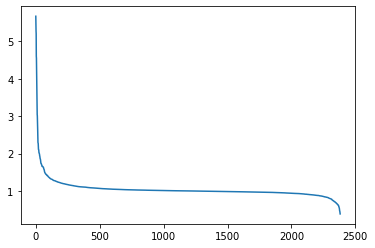

In [15]:
df_results= pd.read_csv("dstd_scores_6.csv").drop(columns="Unnamed: 0")
df_results = df_results.sort_values(by='dstd_score_pos_15', ascending=False).reset_index(drop=True)
df_results.dstd_score_pos_15.plot(legend=False)


features = ['min_time', 'max_time', 'min_amplitude', 'max_amplitude', "dU_min", "dU_max", "dstd_max",  'dstd_score_pos_15', 'dstd_score_elpos_15', 'dstd_score_pos_15_exp', 
           'dstd_score_elpos_15_exp','dstd_score_pos_15_tuk', 'dstd_score_elpos_15_tuk', 'wiggle_area_pos','wiggle_area_elpos']

In [50]:
def plot_wiggle_analysis(df_results, show_n_quenches, features, sort_feature, time_frame_after_qench = 2):
    
    for i, row in df_results[:show_n_quenches].iterrows():
        circuit_name = row["Circuit Name"]
        timestamp_fgc = row["timestamp_fgc"]
        fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"

        data_dir = data_path / (fpa_identifier + ".hdf5")
        df_data_nxcals = load_u_diode_nxcals(data_dir)

        df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & (mp3_fpa_df["Circuit Name"] == circuit_name)]
        
        quench_times=df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
        
        sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                         all_quenched_magnets=df_subset.Position.values, 
                                         quench_times=quench_times, 
                                         time_frame=time_frame_after_qench)
        
        
        sec_quench_number = int(row["sec_quench_number"])

        df_std = get_std_of_diff(df=sec_quenches[sec_quench_number])

        df_std_meta = sort_by_metadata(                                    
            df=df_std, 
            quenched_magnet=df_subset.Position.values[sec_quench_number+1],
            circuit=row["Circuit Name"],
            by="Position")

        df_std_meta_elpos = sort_by_metadata(                                    
            df=df_std, 
            quenched_magnet=df_subset.Position.values[sec_quench_number+1],
            circuit=circuit_name,
            by="#Electric_EE")
        
        #look at secondary quenches within currently analyses secondary quench
        quenches_within_frame = [q for q in quench_times if (q > quench_times[sec_quench_number+1]) & (q < quench_times[sec_quench_number+1] + time_frame_after_qench) ]
        
        fig, ax = plt.subplots(1,5, figsize=(25,4))
        df_data_nxcals.plot(legend=False, ax=ax[0])
        ax[0].set_title(f"{fpa_identifier} \n {Time.to_string(timestamp_fgc)}")
        ax[0].set_xlabel("Time \ s")
        ax[0].set_ylabel("Voltage \ V")
        ax[0].axvline(quench_times[sec_quench_number+1], color='b', linestyle='--')
        

        sec_quenches[sec_quench_number].plot(legend=False, ax=ax[1])
        ax[1].set_title(f"U_diode, zoom in to quench nr.: {sec_quench_number+2} ({row['Position']})") #no primary, start from 0
        ax[1].set_xlabel("Time \ s")
        ax[1].set_ylabel("Voltage \ V")
        for quench_within_frame in quenches_within_frame:
            ax[1].axvline(quench_within_frame, color='b', linestyle='--', label="time of next quench")
            

        sec_quenches[sec_quench_number].diff().plot(legend=False, ax=ax[2])
        ax[2].set_title("dU_diode")
        ax[2].set_xlabel("Time \ s")
        ax[2].set_ylabel("Voltage \ s")
        ax[2].set_ylim((df_results[:show_n_quenches].dU_min.min()*1.1,df_results[:show_n_quenches].dU_max.max()*1.1))
        for quench_within_frame in quenches_within_frame:
            ax[2].axvline(quench_within_frame, color='b', linestyle='--', label="time of next quench")

        df_std_meta.plot(x ="distance_to_quench", y="dstd", ax=ax[3], label="dstd phys. position")
        df_std_meta_elpos.plot(x ="distance_to_quench", y="dstd", ax=ax[3], label="dstd el. position", zorder=-1)
        ax[3].set_title(f"std of derivative=f(distance to quench)")#" \n std_local/std_global: {row['dstd_score_pos_15']:.1f} (#{i+1})")
        ax[3].set_ylim((0,df_results[:show_n_quenches].dstd_max.max()*1.1))
        
        ax[4].axis('off')
        for j, feature in enumerate(features):
            rank = int(df_results[:show_n_quenches][feature].rank(ascending=False)[i])
            if feature == sort_feature:
                ax[4].text(0, 1-j/len(features), f"{feature}: {row[feature]:.2f} (#{rank})", weight="bold")
            else:
                ax[4].text(0, 1-j/len(features), f"{feature}: {row[feature]:.2f} (#{rank})")

        plt.tight_layout()
        fig.show()

# Look at results with ML

In [62]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [89]:
scaler = StandardScaler()
df_tsne = df_results.copy()

df_tsne[features] = scaler.fit_transform(df_tsne[features])
X = df_tsne[features].to_numpy(dtype=np.float64)

X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rele

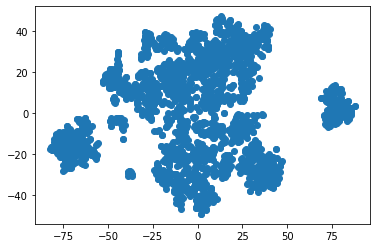

In [92]:
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1])

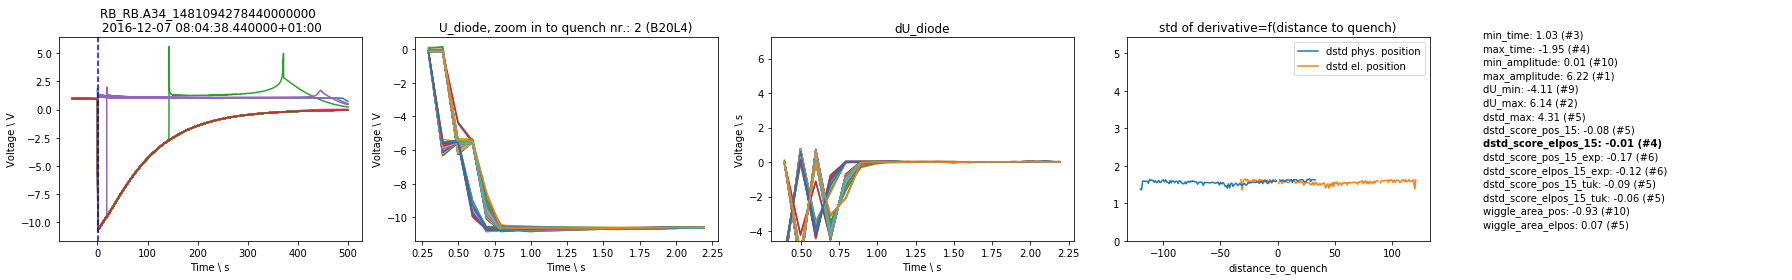

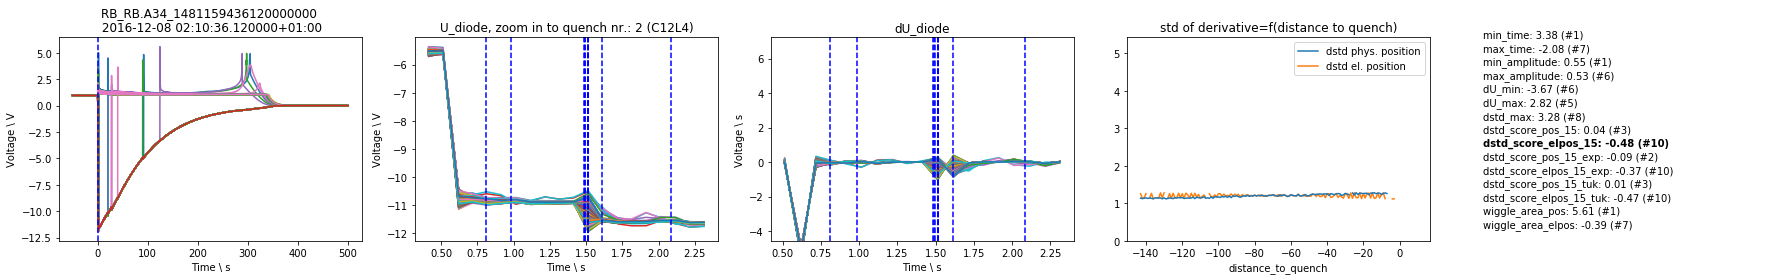

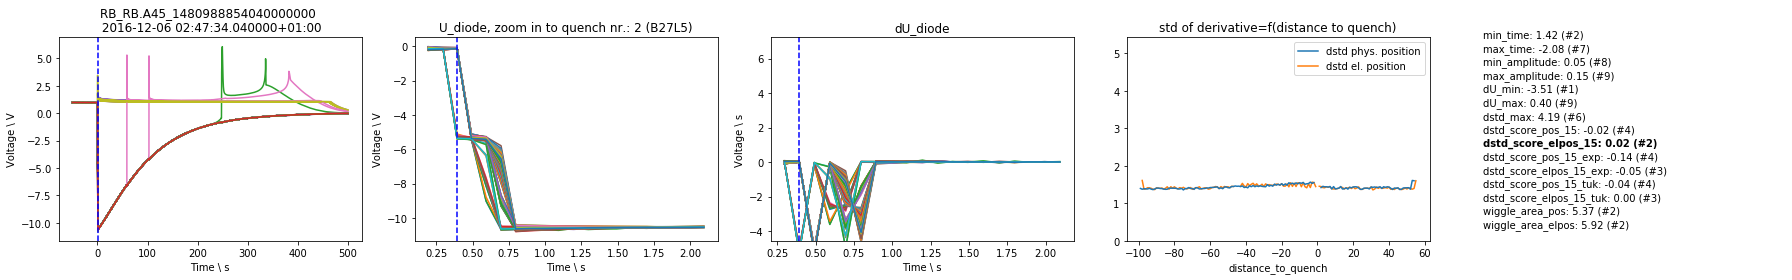

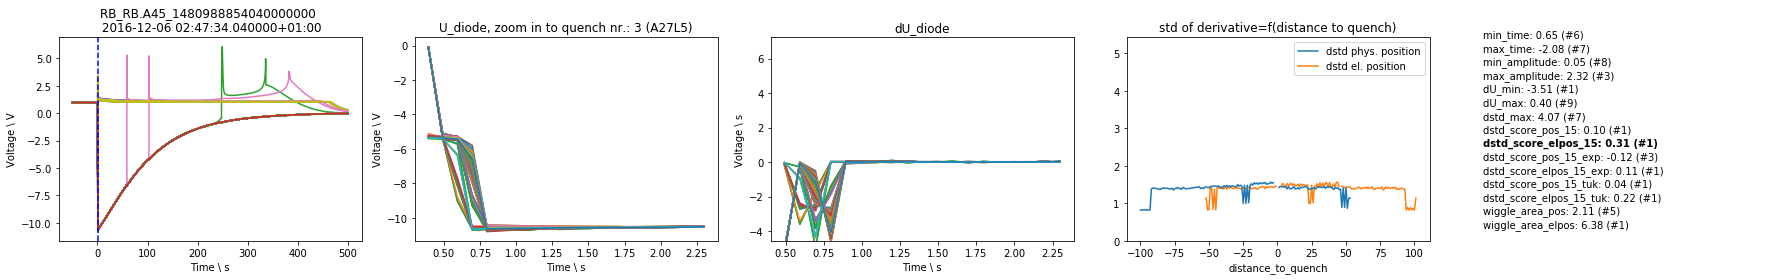

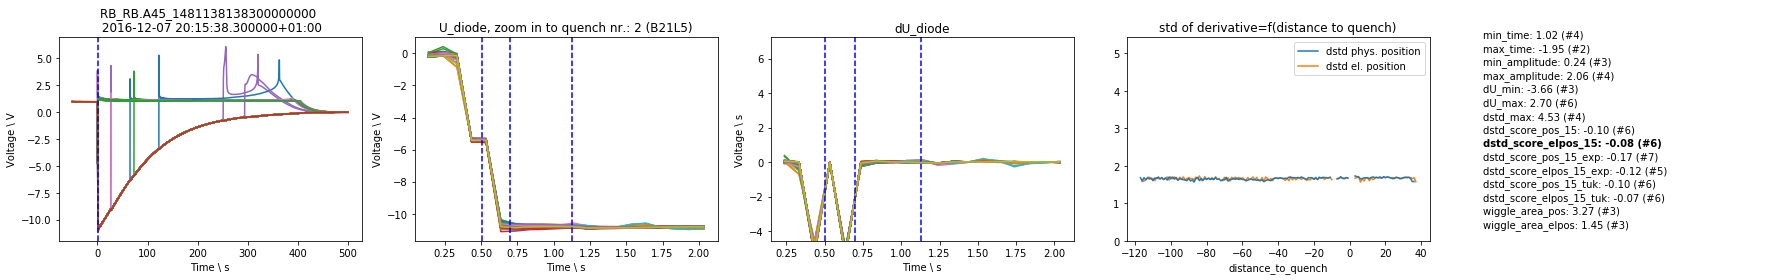

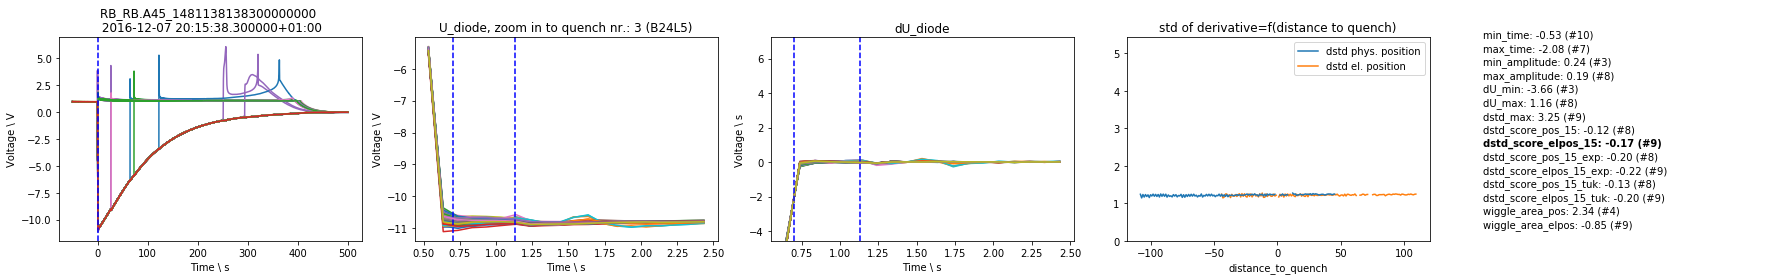

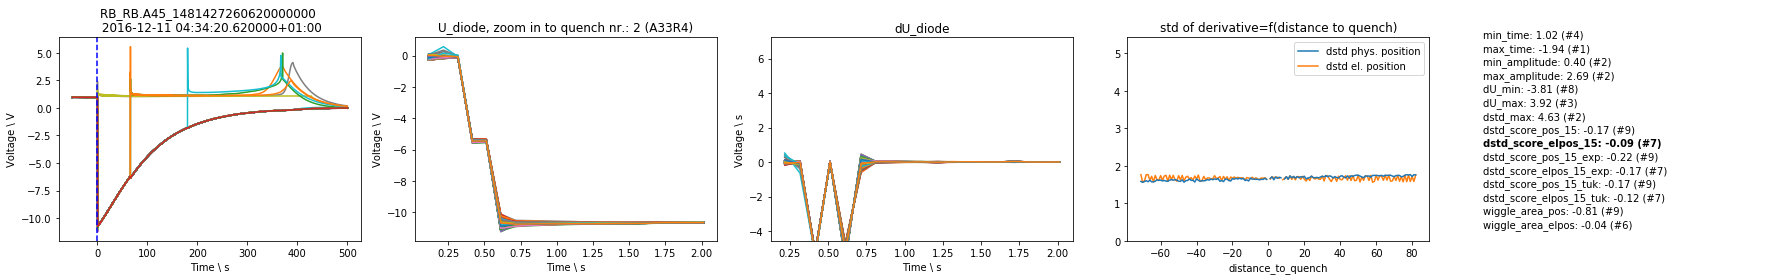

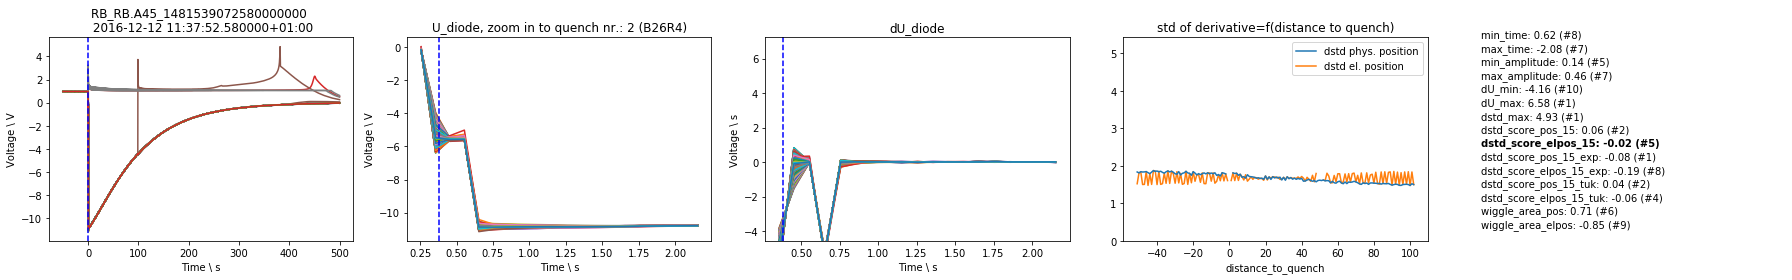

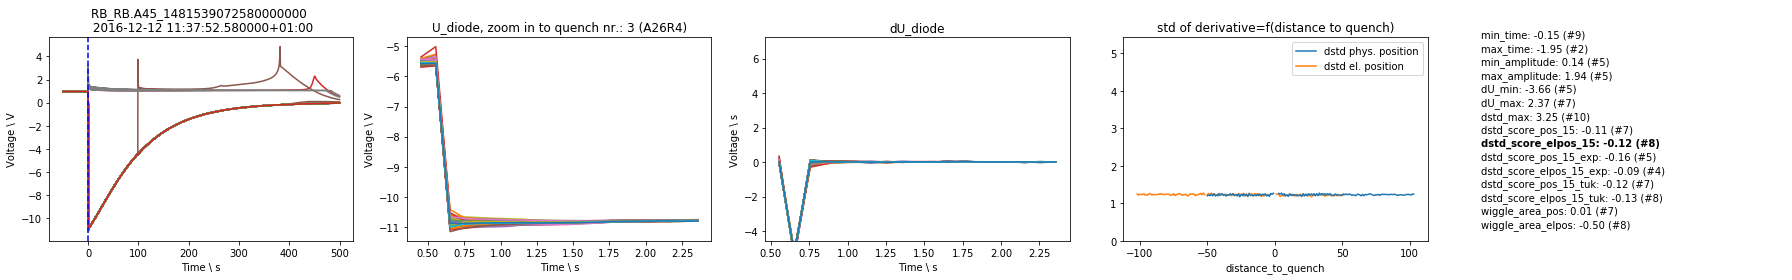

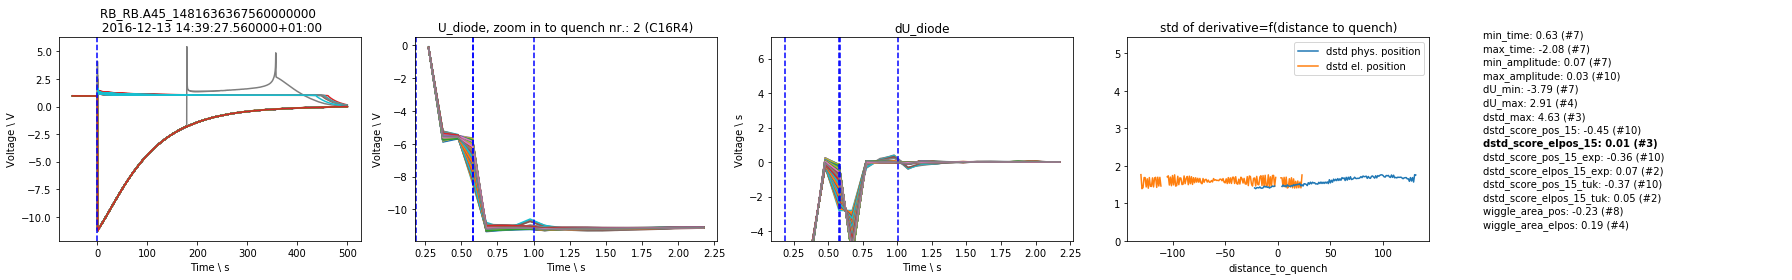

In [96]:
plot_wiggle_analysis(df_tsne.loc[X_embedded[:,0]>50], 10, features, sort_feature)

# Type 1 oscillation, propagation only electrically

In [102]:
sort_feature = 'dstd_score_elpos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

# define manual thresholds to find type 1
df_plot = df_plot[df_plot["dstd_max"]>=0.05]
#df_plot = df_plot[df_plot['dstd_score_elpos_15_exp']>=df_plot['dstd_score_pos_15_exp']]
len(df_plot)

214

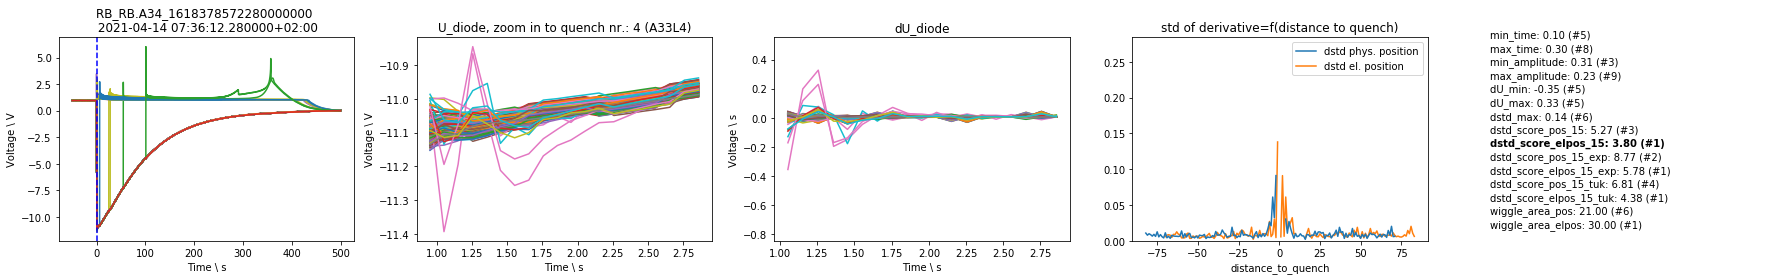

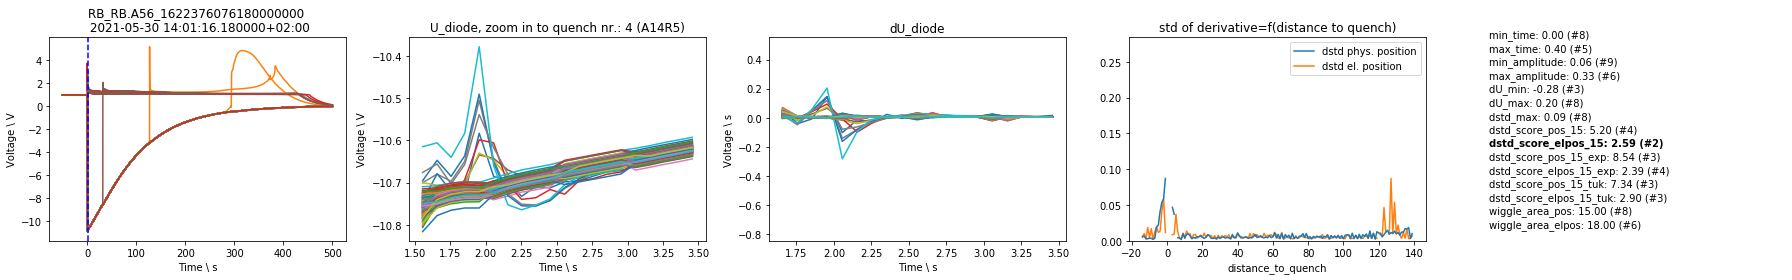

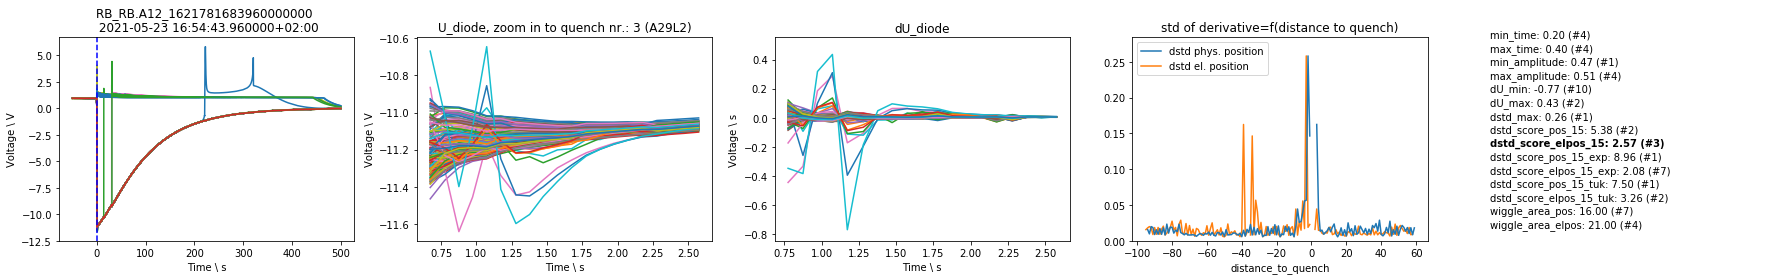

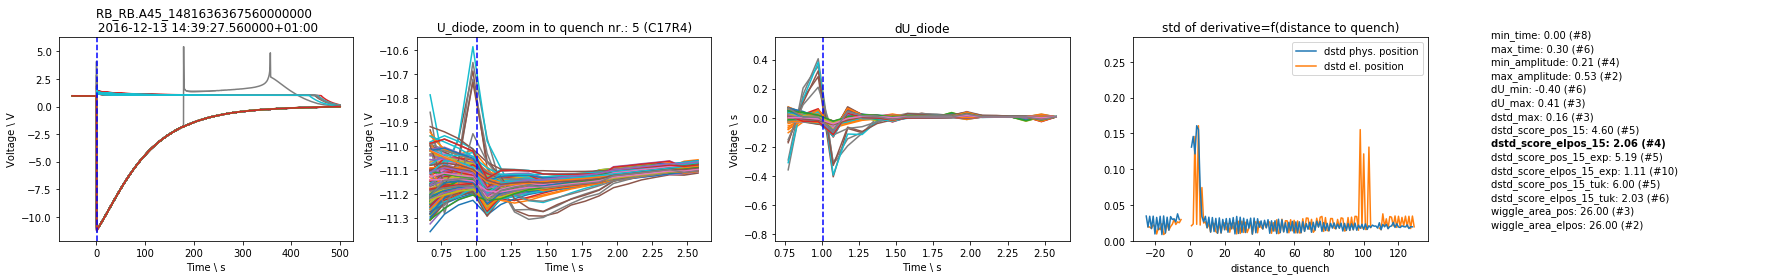

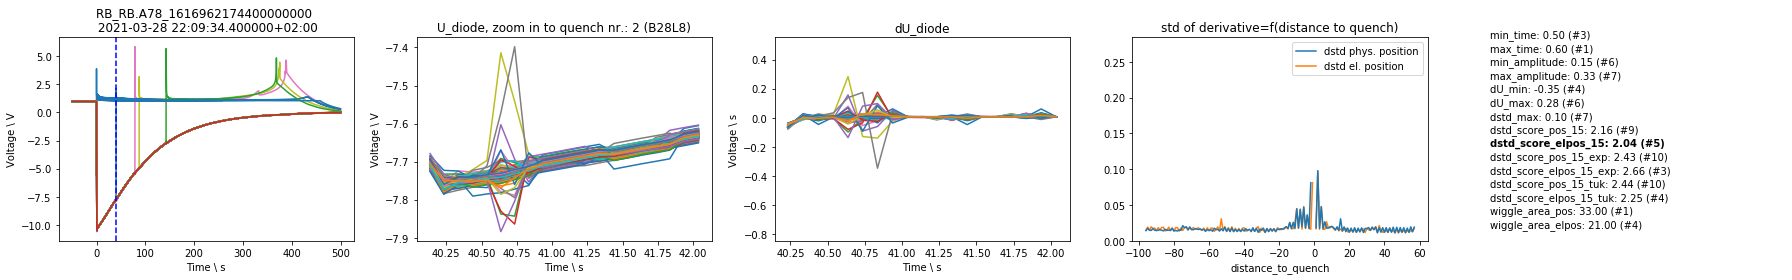

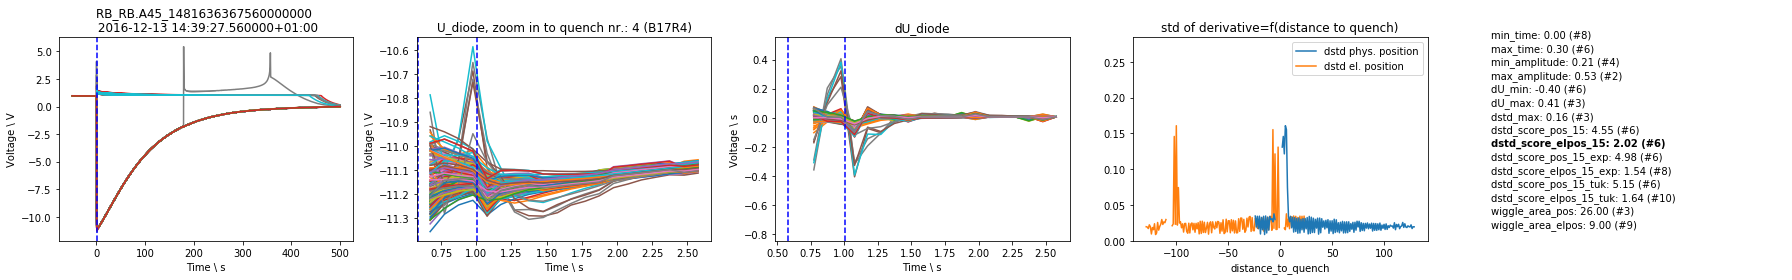

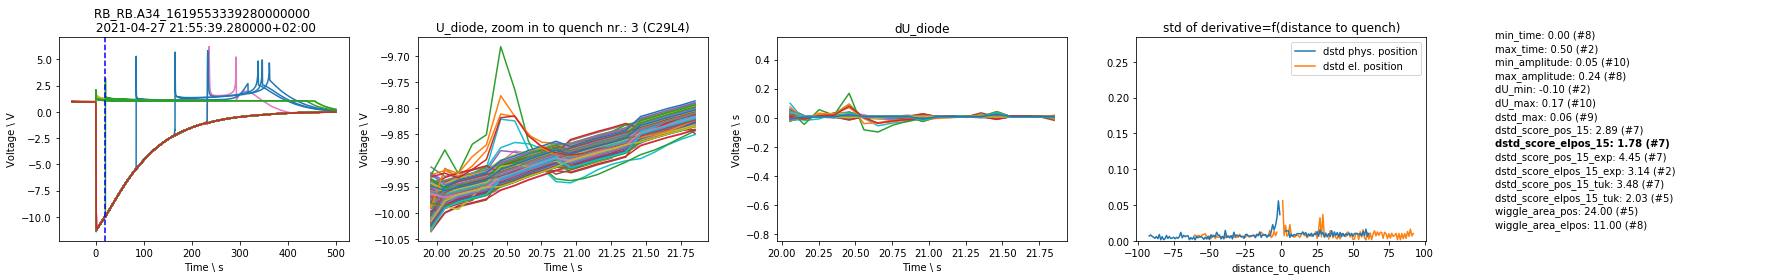

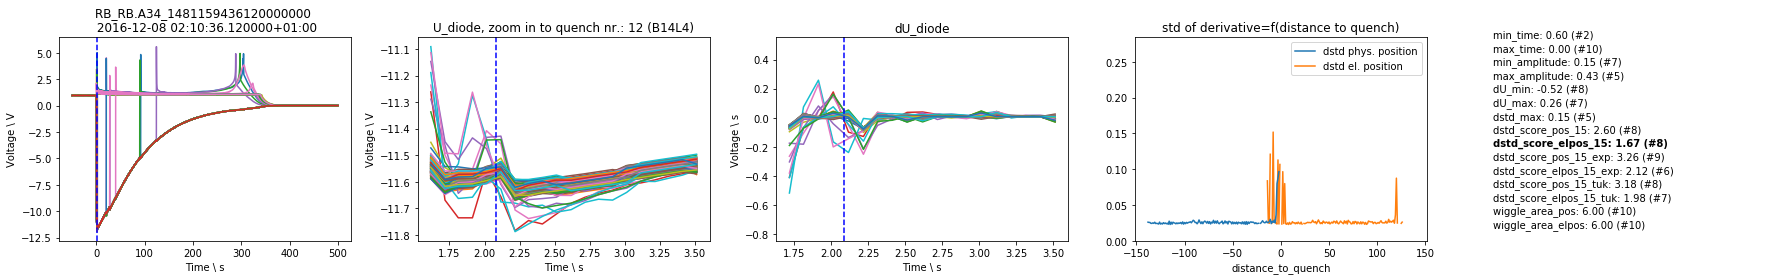

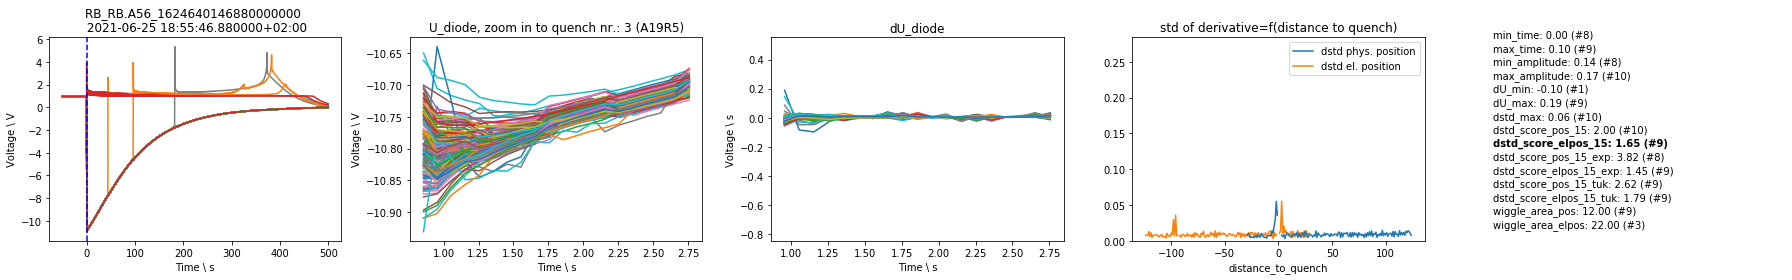

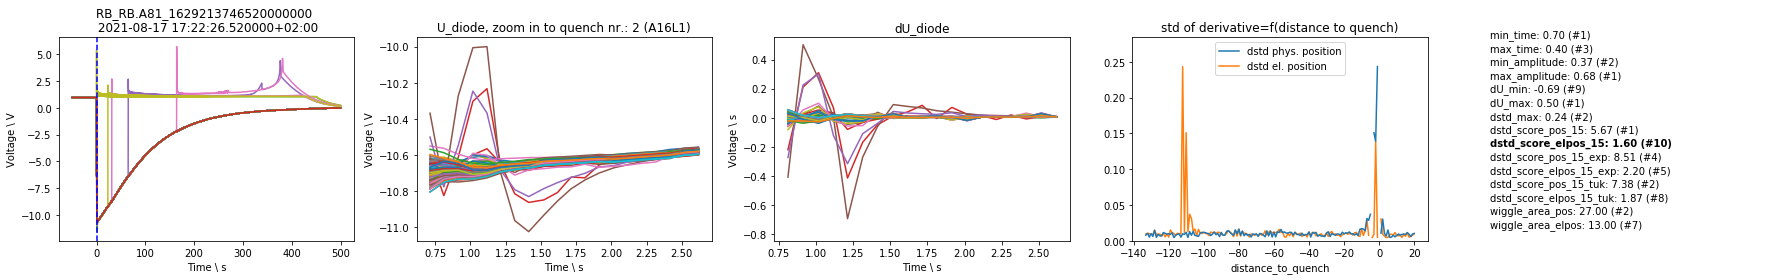

In [103]:
show_n_quenches = 10
plot_wiggle_analysis(df_plot, show_n_quenches, features, sort_feature)

# Type 2 Oscillation that propagates physically and electrically

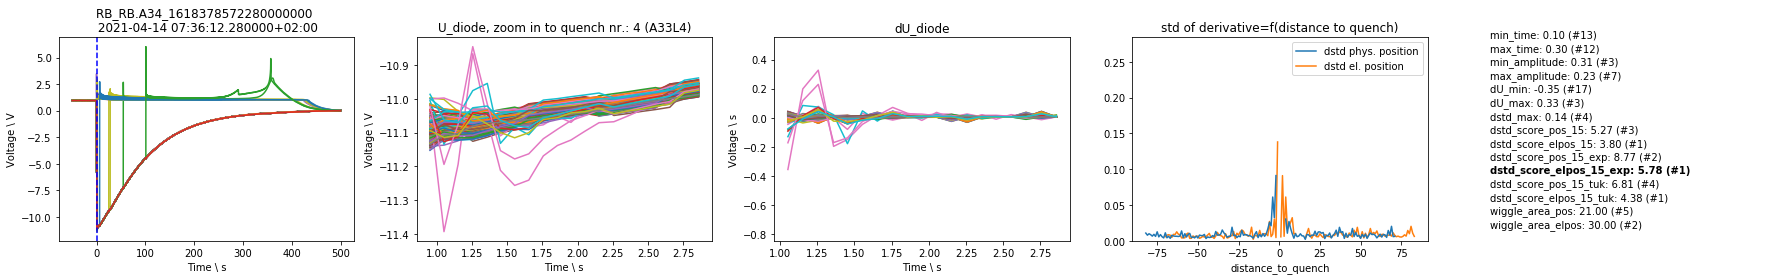

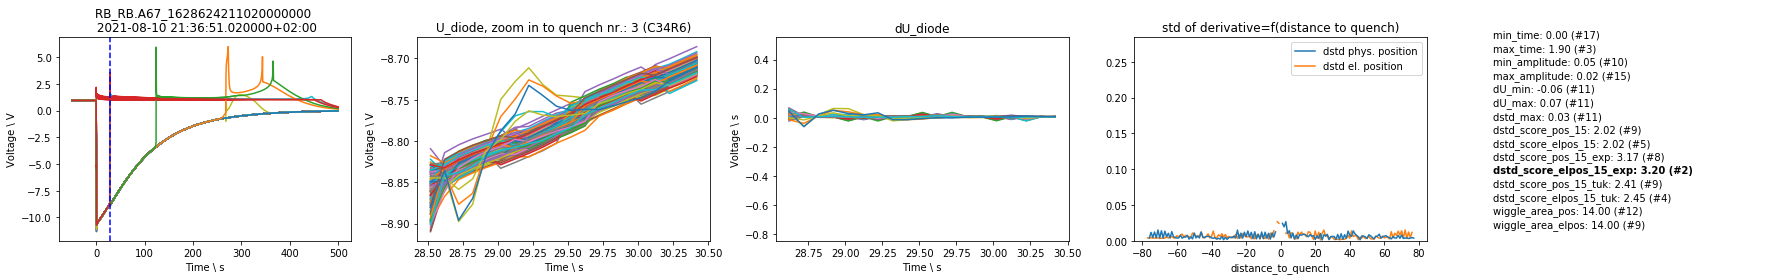

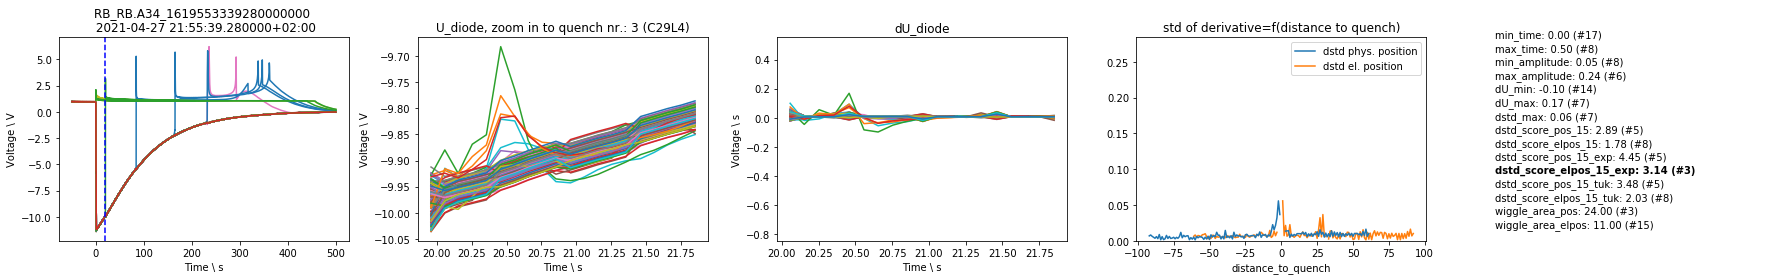

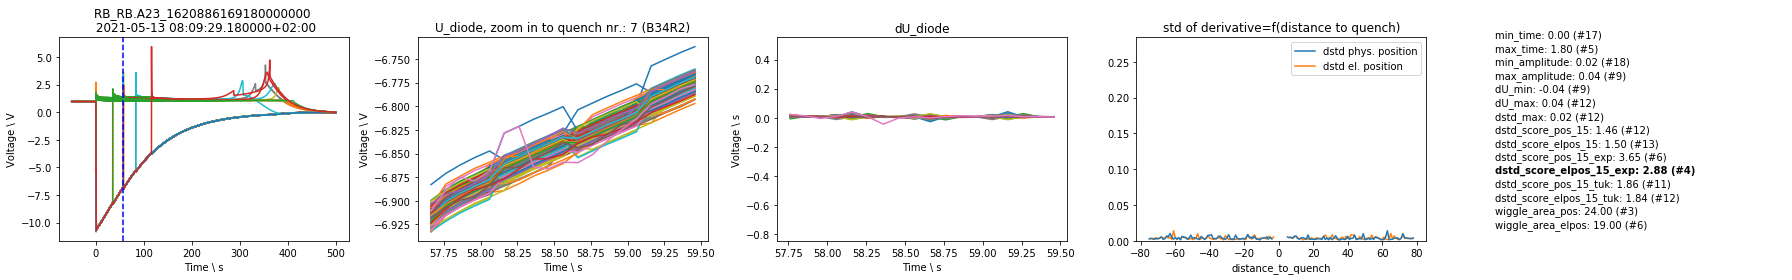

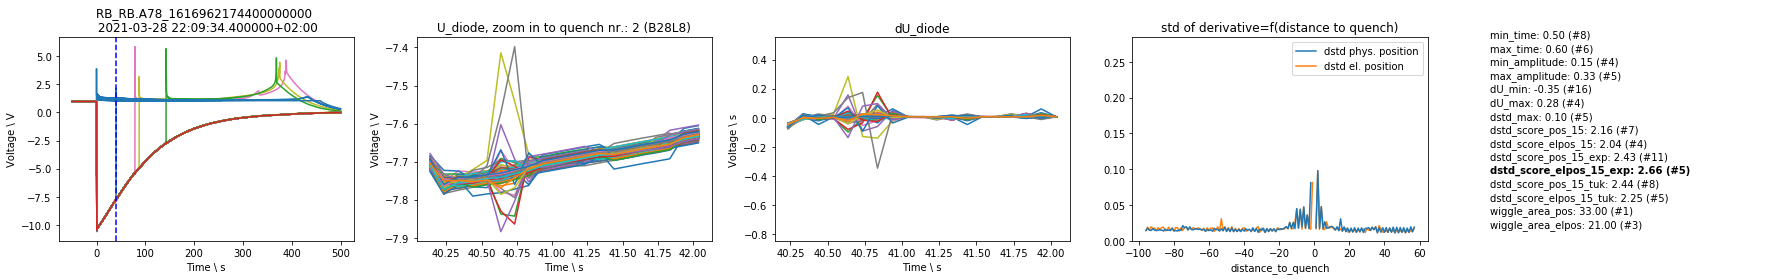

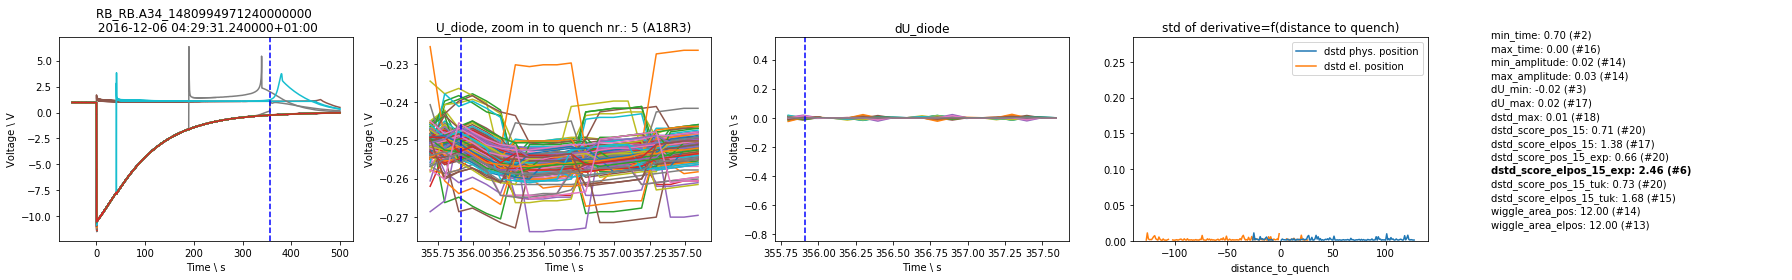

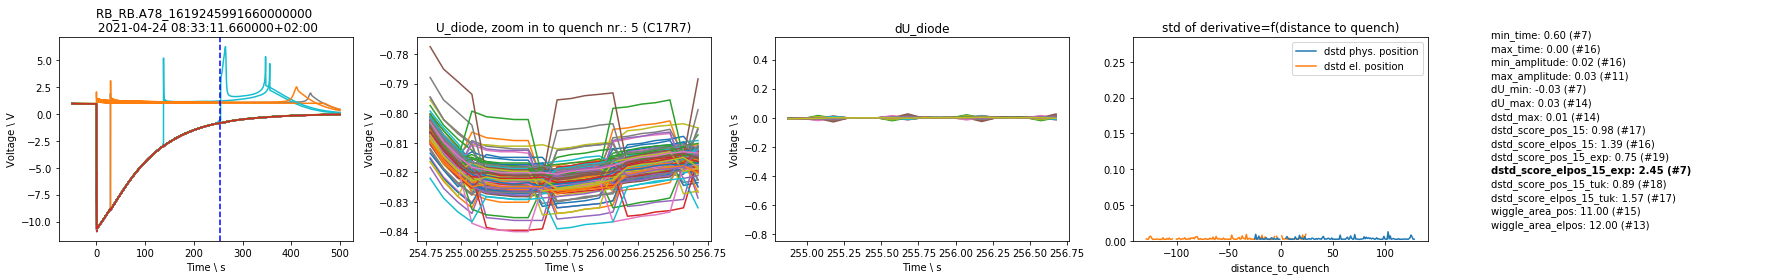

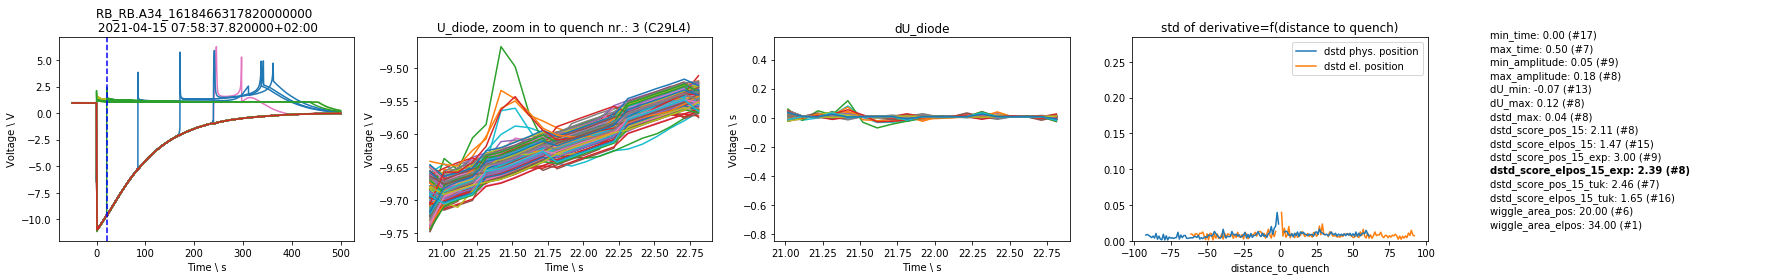

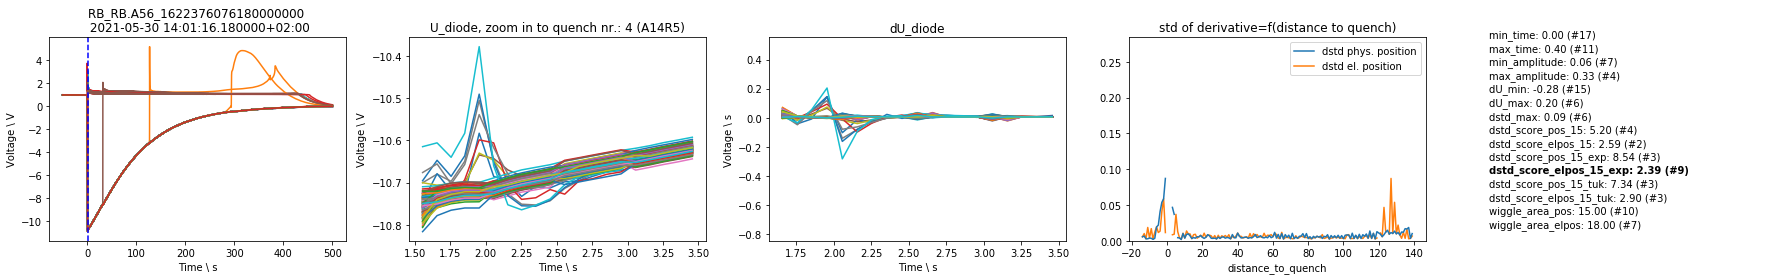

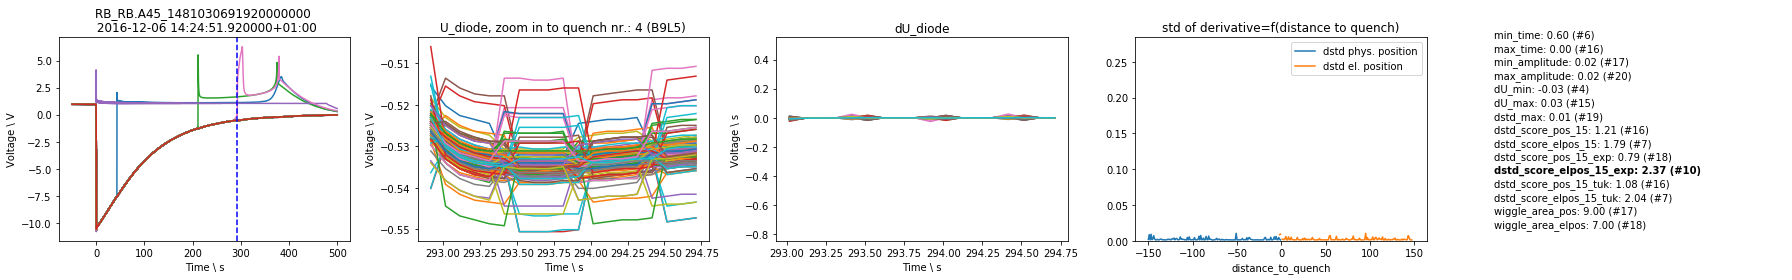

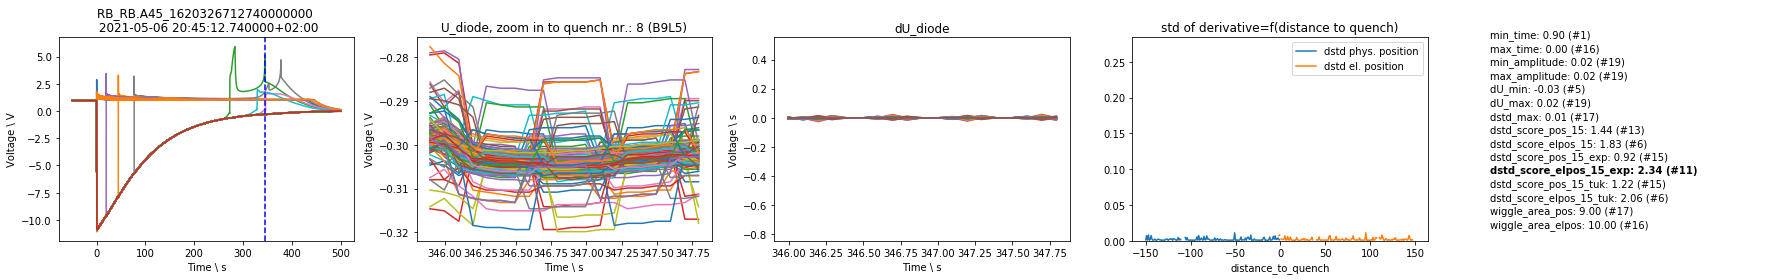

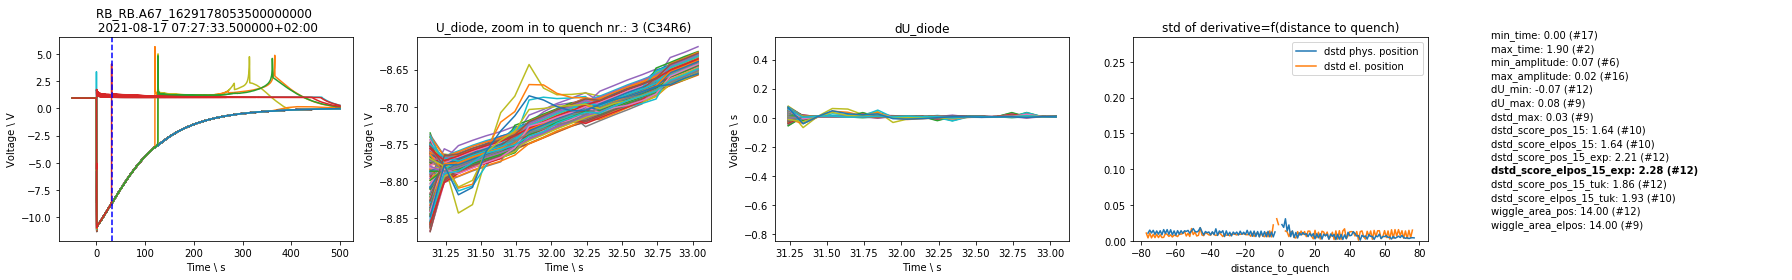

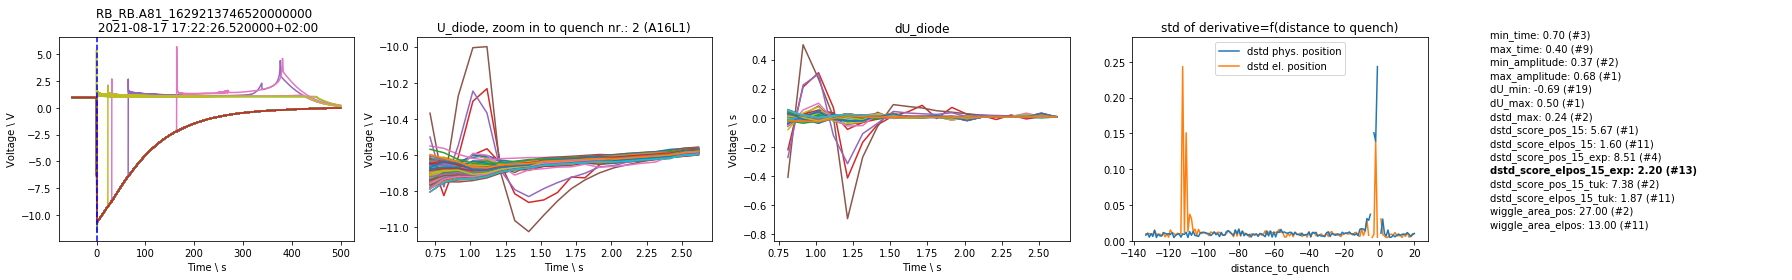

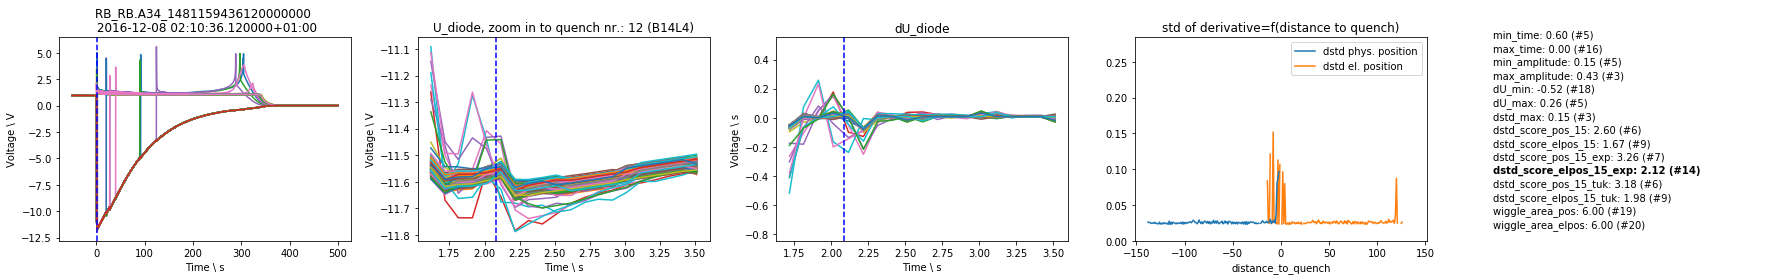

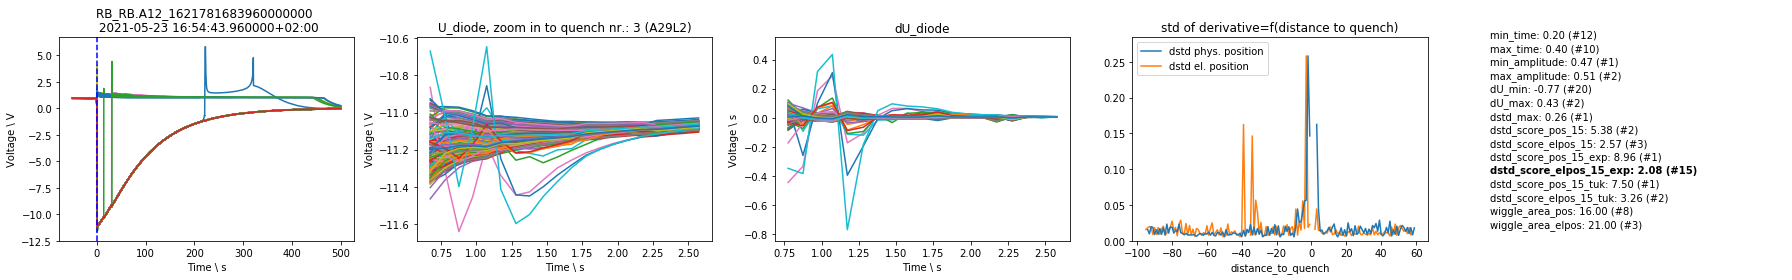

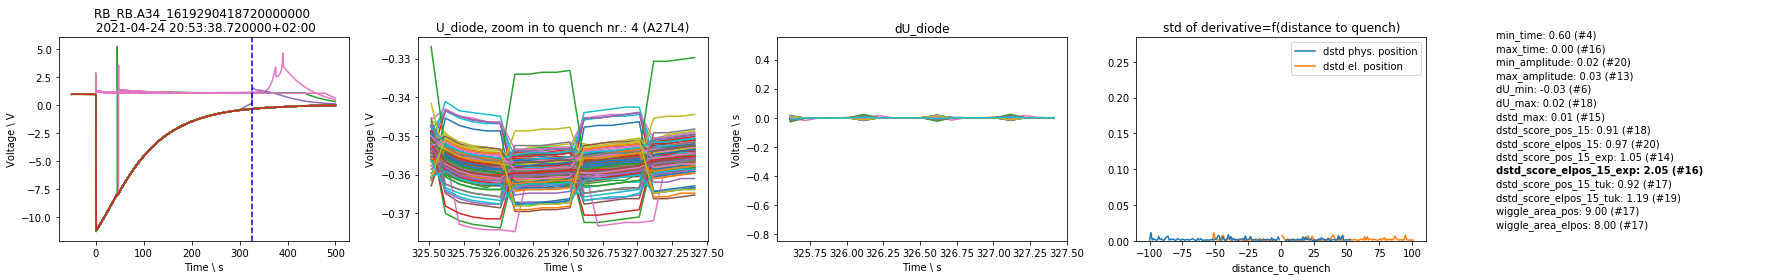

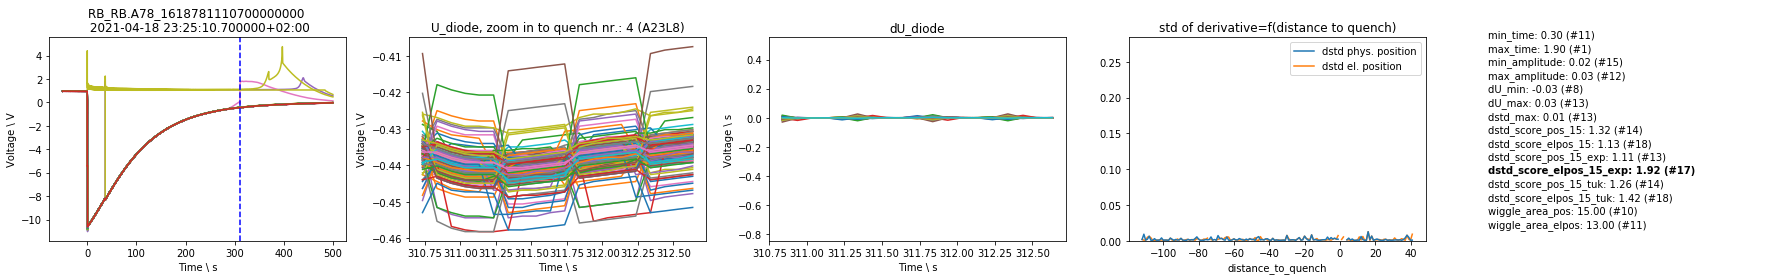

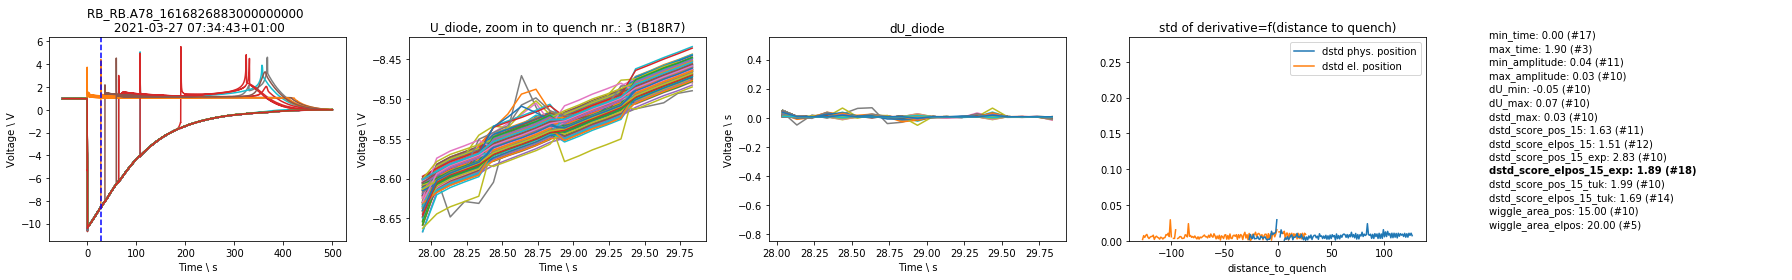

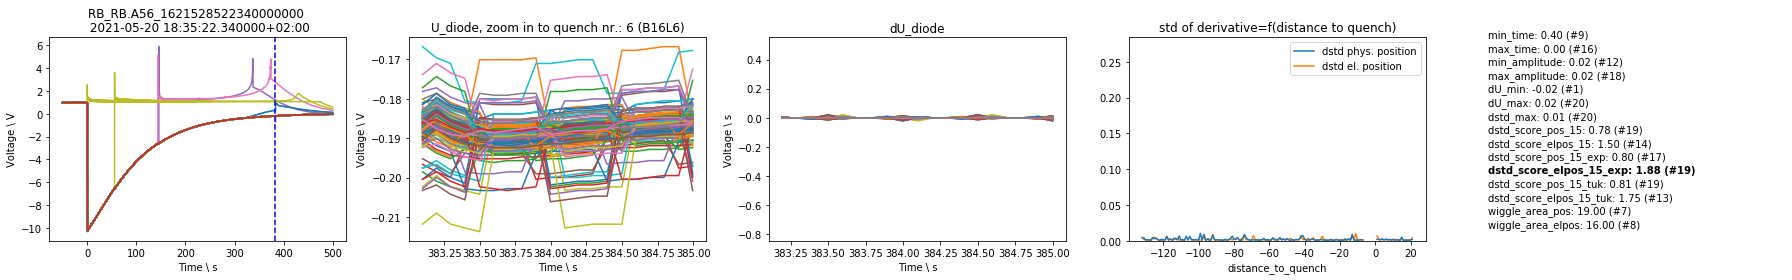

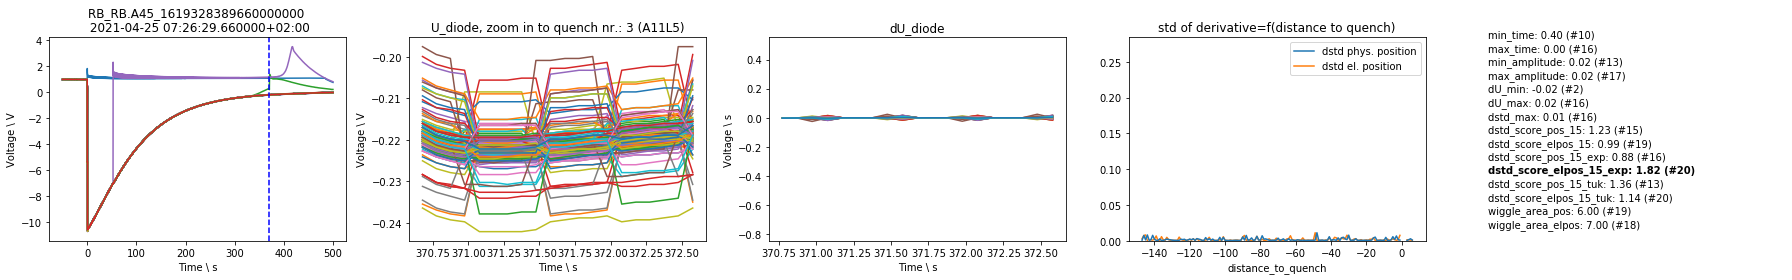

In [34]:
sort_feature = 'dstd_score_elpos_15_exp'

show_n_quenches = 20
plot_wiggle_analysis(df_results, show_n_quenches, features, sort_feature)